In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
import itertools

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from importlib import reload

# local imports
sys.path.append("./")
import utils

In [2]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

# Load our data

In [3]:
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run3/scanpy/anndata_distance.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run4/scanpy/anndata_distance.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_HSC/scanpy/anndata_distance.h5ad"
fpath = "/scratch/indikar_root/indikar1/cstansbu/all_HSC/scanpy/anndata_tabula_merged.h5ad"

adata = sc.read_h5ad(fpath)
adata.var_names_make_unique()

# annotate all labels
adata.obs['group'] = np.where(adata.obs['cluster_name'].isna(), "C5", adata.obs['cluster_name'])
adata.obs['group'] = np.where(adata.obs['celltype'] == 'HSC', "C6", adata.obs['group'])

adata

AnnData object with n_obs × n_vars = 35821 × 14420
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'imputed', 'log_tpm', 'raw_counts'

# make trainning data

In [26]:
# needs to be a mix of FB and hsc cells
train = utils.get_stacked_cell_data(adata, genes=None)
train = train[train.obs['set'] == 'ref_data']

print(train.obs['set'].value_counts())
print()
print(train.obs['group'].value_counts())
print()
train

ref_data    8475
Name: set, dtype: int64

C5    7715
C6     760
Name: group, dtype: int64



View of AnnData object with n_obs × n_vars = 8475 × 14420
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'imputed', 'log_tpm', 'raw_counts'

In [27]:
# build training labels
train.obs['y'] = np.where(train.obs['group'] == 'C5', 1, -1)
print(train.obs['y'].value_counts())
y = train.obs['y'].values

# build features
layer = 'imputed'
X = train.to_df(layer=layer)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print()
print(f"{X_train.shape=}")
print(f"{X_test.shape=}")
print()
print(f"{y_train.shape=}")
print(f"{y_test.shape=}")

 1    7715
-1     760
Name: y, dtype: int64

X_train.shape=(5678, 14420)
X_test.shape=(2797, 14420)

y_train.shape=(5678,)
y_test.shape=(2797,)


# train a simple model

In [28]:
clf = RandomForestClassifier(n_estimators=1000, 
                             max_depth=50,
                             criterion='entropy', 
                             min_samples_split=10,
                             max_features=1500,
                            )

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print(y_pred[0:5])
print()
print(y_proba[0:5, :])
print()

res = sklearn.metrics.classification_report(y_test, y_pred)
print(res)

[-1  1  1  1  1]

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       258
           1       1.00      1.00      1.00      2539

    accuracy                           1.00      2797
   macro avg       1.00      1.00      1.00      2797
weighted avg       1.00      1.00      1.00      2797



Fri Jan 19 14:16:26 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


      gene_name  importance
8731   C11orf96    0.048988
5873      CALD1    0.036873
6993      CEBPD    0.032918
10688     NR2F2    0.030920
11070      MMP2    0.029934
                                           path_name  adj_p_val  \
0                membrane raft assembly (GO:0001765)   0.000065   
1  regulation of cardiac muscle cell apoptotic pr...   0.000268   
2            membrane raft organization (GO:0031579)   0.000490   
3  positive regulation of vascular associated smo...   0.001065   
4                     membrane assembly (GO:0071709)   0.004071   

         overlapping_genes  
0   [ANXA2, EMP2, S100A10]  
1  [CAMK2D, NUPR1, BMPR1A]  
2   [ANXA2, EMP2, S100A10]  
3   [IGFBP5, MMP2, BMPR1A]  
4   [ANXA2, EMP2, S100A10]  


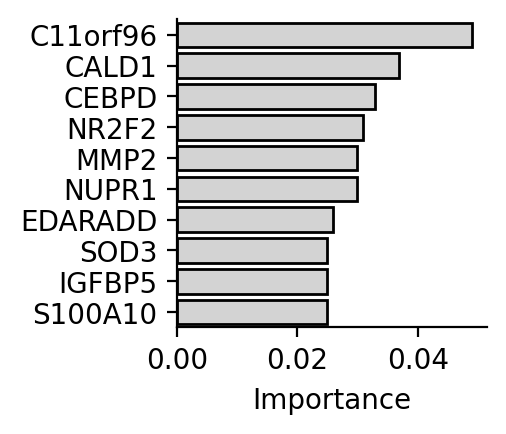

In [29]:
n_plot = 10
n_query = 35
imp = pd.DataFrame({
    'gene_name' : X.columns.to_list(),
    'importance' : clf.feature_importances_,
})

imp = imp.sort_values(by='importance', ascending=False)
print(imp.head())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, n_plot // 4.5

sns.barplot(data=imp.head(n_plot),
            x='importance',
            y='gene_name',
            color='lightgrey',
            ec='k')

plt.ylabel("")
plt.xlabel("Importance")
sns.despine()

database= 'ontology'
edf = gget.enrichr(imp['gene_name'].head(n_query).to_list(), 
                   database=database)

print(edf[['path_name','adj_p_val', 'overlapping_genes']].head())

# Evaulate on our data

In [30]:
pdf = utils.get_stacked_cell_data(adata, genes=None)
pdf = pdf[pdf.obs['set'] == 'our_data']

data = pdf.to_df(layer=layer)
probs = clf.predict_proba(data)
probs = pd.DataFrame(probs, columns=['HSC', "FB"], index=pdf.obs_names)
probs['pred'] = clf.predict(data)

pdf.obs = pd.merge(pdf.obs, probs,
                   how='left', 
                   left_index=True,
                   right_index=True,)

pdf

AnnData object with n_obs × n_vars = 8475 × 14420
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group', 'HSC', 'FB', 'pred'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'imputed', 'log_tpm', 'raw_counts'

# Plot the results

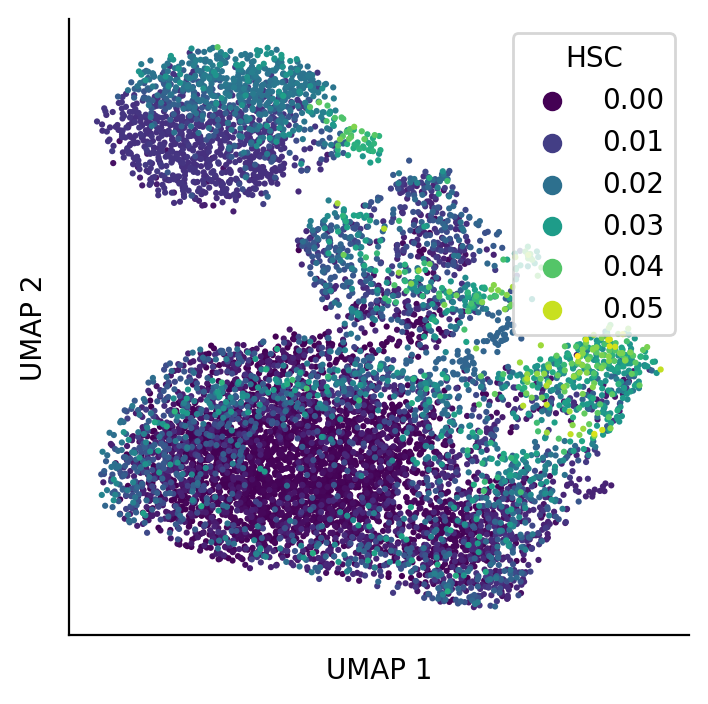

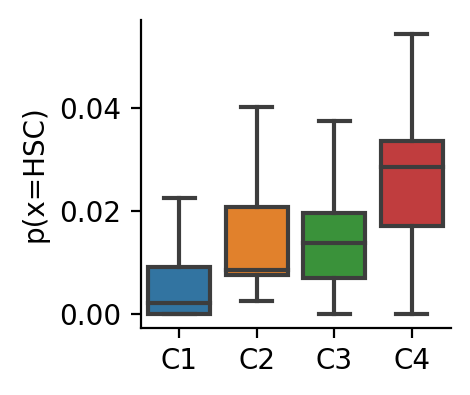

In [31]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# column = 'pred'
column = 'HSC'
# order = np.argsort(pdf.obs[column])[::-1]
order = np.argsort(pdf.obs[column])

sns.scatterplot(data=pdf.obs.iloc[order],
                x='UMAP 1', 
                y='UMAP 2',
                s=5,
                hue=column,
                palette='viridis',
                ec='none')

plt.yticks([])
plt.xticks([])
sns.despine()

plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2

sns.boxplot(data=pdf.obs,
            y=column,
            x='cluster_name',
            showfliers=False)

plt.ylabel(f"p(x={column})")
plt.xlabel("")
sns.despine()

# plot the most important genes

ValueError: AxesSubplot(0.125,0.11;0.775x0.77) has no legend attached.

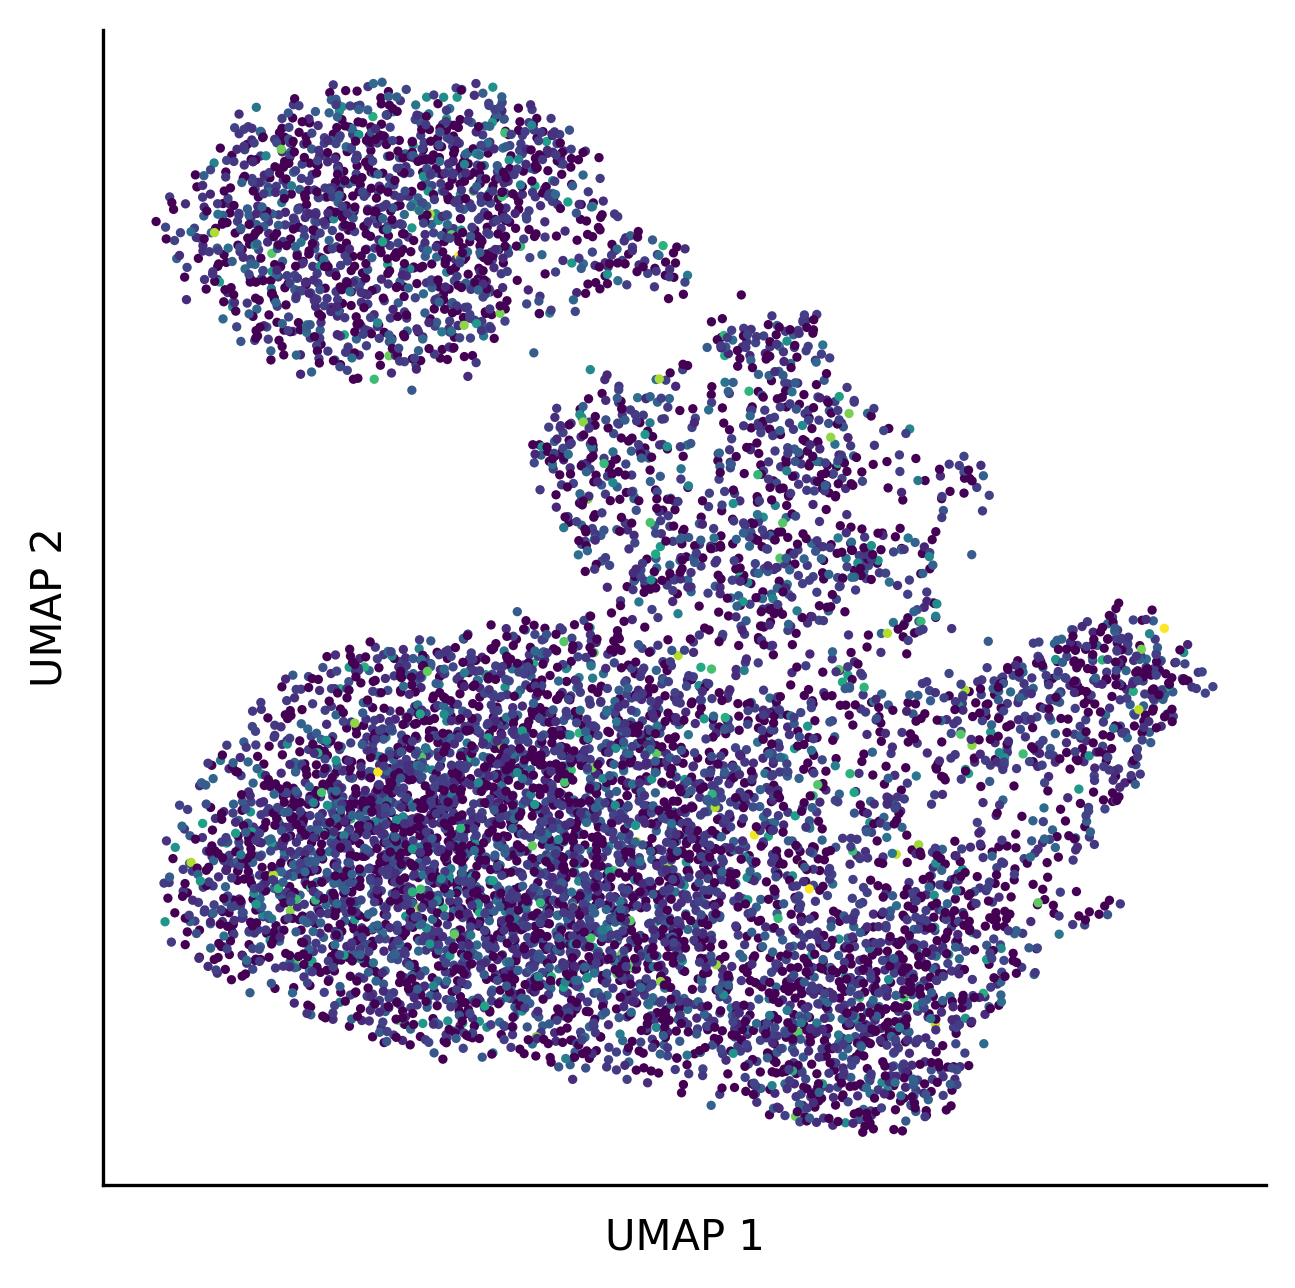

In [32]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

n_genes = 5

color = pdf[:, imp['gene_name'].head(n_genes)].X.mean(axis=1)
order = np.argsort(color)

sns.scatterplot(data=pdf.obs.iloc[order],
                x='UMAP 1', 
                y='UMAP 2',
                s=5,
                c=color,
                palette='viridis',
                ec='none')

plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
sns.despine()

sns.move_legend(plt.gca(),
                loc='upper right',
                title="V5+")

In [ ]:
np.log2(14400)